# Translate device time into concert time
and cut signals to concert intervals

Starting with AX3 recordings

## load libraries

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

# load concert times, cue times, and data file locs

In [4]:
Piece_dt = pd.read_csv('./Timing/ConcertDateTimes.csv',index_col = 0)
# convert relevant columsn into datetime
for c in Piece_dt.columns[3:]:
    Piece_dt.loc[:,c] = pd.to_datetime(Piece_dt.loc[:,c]).dt.tz_convert('UTC')
Piece_dt.loc[:5,:]

,Related,Event_Type,Event,RD,C1,C2,C3,C4,C5
0,Init,Stage,Pre-Audio,NaT,NaT,2023-02-16 10:09:21.319000+00:00,NaT,NaT,2023-02-18 14:54:07.681000+00:00
1,Init,Orch,Warmup,2023-02-15 11:00:36.897000+00:00,2023-02-16 08:27:30.042000+00:00,2023-02-16 10:10:21.394000+00:00,2023-02-17 08:29:58.895000+00:00,2023-02-17 10:10:41.889000+00:00,2023-02-18 15:04:03.121000+00:00
2,Init,Orch,Tuning,2023-02-15 11:04:38.152000+00:00,2023-02-16 08:32:17.013000+00:00,2023-02-16 10:15:33.575000+00:00,2023-02-17 08:30:03.068000+00:00,2023-02-17 10:15:37.905000+00:00,2023-02-18 15:06:43.947000+00:00
3,Init,Orch,Synch Taps,2023-02-15 11:05:36.897000+00:00,2023-02-16 08:33:18.524000+00:00,2023-02-16 10:16:22.697000+00:00,2023-02-17 08:30:51.841000+00:00,2023-02-17 10:16:26.888000+00:00,2023-02-18 15:10:29.583000+00:00
4,Init,Applause,Applause for Conductor,2023-02-15 11:05:56.191000+00:00,2023-02-16 08:33:46.816000+00:00,2023-02-16 10:18:24.711000+00:00,2023-02-17 08:32:07.915000+00:00,2023-02-17 10:16:48.817000+00:00,2023-02-18 15:09:59.446000+00:00
5,Saev,Music,Saevarud,2023-02-15 11:06:20.804000+00:00,2023-02-16 08:34:03.424000+00:00,2023-02-16 11:11:01.919000+00:00,2023-02-17 09:25:39.887000+00:00,2023-02-17 10:16:57.035000+00:00,2023-02-18 15:10:44.919000+00:00


In [5]:
Piece_timings = pd.read_csv('./Timing/ctimes.csv')
Piece_timings.iloc[[3,33],:] 

,Event,RD,C1,C2,C3,C4,C5
3,Synch Taps,0.000,0.000,0.00,0.000,0.000,0.000
33,End,3395.694,3756.436,3535.87,3544.558,3512.995,3602.818


In [6]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.524+0000'), # +0.2
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.446+0000'),# +0.2
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

c_types = {'RE_Synch':'taps',
               'RD_Reic': 'claps',
               'RD_Synch':'taps',
               'RD_Reic2':'claps',
           'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':'claps', # 97.0 
                 'C1_Synch':'taps',
                 'C2_Synch':'taps',
          'C3_Synch':'taps',
               'C3_Reic': 'claps',
               'C4_Synch':'taps',
               'C4_Reic': 'claps',
          'C5_Synch':'taps',
               'C5_Reic': 'claps',}
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',
            'C1_Synch':'./Timing/short_taps.csv',
               'C1_Reic': './Timing/C1_reic_claps.csv',
               'C2_Synch':'./Timing/short_taps.csv',
               'C2_Reic':'./Timing/C2_reic_claps.csv',
            'C3_Synch':'./Timing/short_taps.csv',
               'C3_Reic': './Timing/C3_reic_claps.csv',
               'C4_Synch':'./Timing/short_taps.csv',
               'C4_Reic':'./Timing/C4_reic_claps.csv',
           'C5_Synch':'./Timing/short_taps.csv',
               'C5_Reic': './Timing/C5_claps.csv',} 

CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-5,10]
for c in synch_times.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)
    CueT[c] = cue 

In [7]:
cues_aligned = pd.read_csv('RE_RD_Equivitals.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_Equivitals.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
#cues_aligned

55


In [9]:
Part_Dets = pd.read_csv('../Data/Participant_Metadata.csv', index_col = 0)
EQ_users = Part_Dets.loc[Part_Dets.loc[:,['P_RG', 'P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']].sum(axis=1)>0,['P_RG', 'P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']]
for c in ['P_RG', 'P_RE', 'P_RD', 'P_C1', 'P_C2', 'P_C3', 'P_C4', 'P_C5']:
    EQ_users.loc[EQ_users.loc[:,c].isna(),c] = 0.0
    EQ_users.loc[:,c] = EQ_users.loc[:,c].astype('int32').astype('str')
eq_files=pd.read_csv('raw_EQ_filelocs.csv',index_col = 0)

In [10]:
df = (cues_aligned - synch_times)#.dt.total_seconds() # (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()
for c in df.columns:
    df[c] = df[c].dt.total_seconds()
df.median()

RE_Synch    0.490
RD_Synch    0.310
RD_Reic     0.370
RD_Reic2    0.150
C1_Synch    0.990
C1_Reic     0.935
C2_Synch    0.485
C2_Reic     0.420
C3_Synch    0.425
C3_Reic     0.375
C4_Synch   -0.050
C4_Reic    -0.095
C5_Synch    2.740
C5_Reic     2.775
dtype: float64

In [11]:
cue_time_map = pd.DataFrame(index = cues_aligned.columns,columns = ['dt_UTC','cTime_s','rTime_s'])
cue_time_map['dt_UTC'] = pd.Series(synch_times)
rec_days = {'Re':['RE_Synch', 'RD_Synch', 'RD_Reic','RD_Reic2'], #, 'RD_Reic2'
            'D1':['C1_Synch', 'C1_Reic','C2_Synch', 'C2_Reic'],
           'D2':['C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic'],
            'D3':['C5_Synch', 'C5_Reic']}
sync_days = {'Re':'RE_Synch',
            'D1':'C1_Synch',
            'D2':'C3_Synch',
            'D3':'C5_Synch'}
rec_con = {'RE':['RE_Synch'],
           'RD':['RD_Synch', 'RD_Reic','RD_Reic2'],#, 'RD_Reic2'
           'C1':['C1_Synch', 'C1_Reic'],
           'C2':['C2_Synch', 'C2_Reic'],
           'C3':['C3_Synch', 'C3_Reic'],
           'C4':[ 'C4_Synch', 'C4_Reic'],
           'C5':['C5_Synch', 'C5_Reic']}
sync_con = {'RG':'RE_Synch',
            'RE':'RE_Synch',
            'RD':'RD_Synch',
            'C1':'C1_Synch',
            'C2':'C2_Synch', 
            'C3':'C3_Synch',
            'C4':'C4_Synch',
            'C5':'C5_Synch'}

for s in rec_days.keys():
    cue_time_map.loc[rec_days[s],'rTime_s'] = (cue_time_map.loc[rec_days[s],'dt_UTC']-cue_time_map.loc[sync_days[s],'dt_UTC']).dt.total_seconds()
for s in rec_con.keys():
    cue_time_map.loc[rec_con[s],'cTime_s'] = (cue_time_map.loc[rec_con[s],'dt_UTC']-cue_time_map.loc[sync_con[s],'dt_UTC']).dt.total_seconds()

#cue_time_map.loc[[],'cTime_s'] = 
cue_time_map.to_csv('./Timing/cue_times_mapping.csv')
cue_time_map

,dt_UTC,cTime_s,rTime_s
RE_Synch,2023-02-15 10:25:26.573000+00:00,0.0,0.0
RD_Synch,2023-02-15 11:05:36.897000+00:00,0.0,2410.324
RD_Reic,2023-02-15 11:16:50.919000+00:00,674.022,3084.346
RD_Reic2,2023-02-15 12:02:00.040000+00:00,3383.143,5793.467
C1_Synch,2023-02-16 08:33:18.524000+00:00,0.0,0.0
C1_Reic,2023-02-16 08:45:22.446000+00:00,723.922,723.922
C2_Synch,2023-02-16 10:16:22.697000+00:00,0.0,6184.173
C2_Reic,2023-02-16 10:27:10.927000+00:00,648.23,6832.403
C3_Synch,2023-02-17 08:30:51.841000+00:00,0.0,0.0
C3_Reic,2023-02-17 08:40:31.007000+00:00,579.166,579.166


# translate device recording times to concert times
with just offset (sync or Reic if sync is missing)

In [12]:
eq_files=pd.read_csv('raw_EQ_filelocs.csv',index_col = 0)

print(eq_files.index)
eq_files

Index(['VN102', 'VN107', 'VN106', 'VN108', 'VN101', 'VN105', 'VN103', 'VN104',
       'VN205', 'VN203', 'VN202', 'VN206', 'VN209', 'VN210', 'VN207', 'VN208',
       'VN201', 'VN204', 'VA305', 'VA307', 'VA308', 'VA301', 'VA306', 'VA302',
       'VA303', 'VA304', 'LS406', 'LS407', 'LS408', 'LS405', 'LS401', 'LS403',
       'LS402', 'LS410', 'LS404', 'WW505', 'WW502', 'WW503', 'WW506', 'WW501',
       'WW504', 'WW507', 'BR604', 'BR603', 'BR602', 'BR606', 'BR607', 'BR605',
       'BR601', 'PC704', 'PC705', 'PC703', 'PC701', 'PC702', 'PC707'],
      dtype='object')


,RG,RE,RD,C1,C2,C3,C4,C5
VN102,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN102...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN102...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN102...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN102-342...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN102-342...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN107,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN107...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN107...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN107...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN107-502...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN107-502...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN106,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN106...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN106...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN106...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN106-502...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN106-502...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN108,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN108...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN108...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN108...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN108-502...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN108-502...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN101,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN101...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN101...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN101...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN101-342...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN101-342...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN105,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN105...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN105...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN105...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN105-342...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN105-342...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN103,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN103...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN103...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN103...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN103-342...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN103-342...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN104,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN104...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN104...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN104...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN104-342...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN104-342...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN205,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN205...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN205...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN205...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN205-502...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN205-502...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivital/230218_Lydo_Concerts/FASTACC...
VN203,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN203...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN203...,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN203...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN203-502...,../Data/Equivital/Lydo_C1_C2/FASTACC-VN203-502...,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,../Data/Equivit

In [13]:
pid = 'LS401' # WW504    6107.171 vs 6107.9 ish  VN209 half of D1, single LS404 D3
recced = 'Re'
concert = 'RD'
refs = rec_days[recced]
sref = sync_days[recced]
refs 

['RE_Synch', 'RD_Synch', 'RD_Reic', 'RD_Reic2']

In [14]:
sigFileLoc = eq_files.loc[pid,concert]
V = pd.read_csv(sigFileLoc)
V
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_convert('UTC') 
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))


In [15]:
cues_aligned.loc[pid,refs]

RE_Synch   2023-02-15 10:25:27.273000+00:00
RD_Synch   2023-02-15 11:05:37.437000+00:00
RD_Reic    2023-02-15 11:16:51.539000+00:00
RD_Reic2   2023-02-15 12:02:00.440000+00:00
Name: LS401, dtype: datetime64[ns, UTC]

In [16]:

# for this recording interval and sensor, find the earliest and latest detected cues
G = cues_aligned.loc[pid,refs].copy()
subrefs = list(G.loc[~pd.isnull(G)].index)
if len(subrefs)>1:
    sref = subrefs[0]
    eref = subrefs[-1]
    # retain drift_C for stats
    drift_C = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()/(cues_aligned.loc[pid,eref]-cues_aligned.loc[pid,sref]).total_seconds())
    ACC['rTime_s'] = np.round((ACC['dev_dTime']-cues_aligned.loc[pid,sref]).dt.total_seconds()*drift_C,3)+cue_time_map.loc[sref,'rTime_s']
    ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s'],unit='s')+ cue_time_map.loc[sync_days[recced],'dt_UTC']
if len(subrefs)==1:
    sref = subrefs[0]
    drift_C = 1 #default_C # define from average after? or other intervals form that sensor?
if len(subrefs)<1:
    print('No signal')

### Check to see if the realignment is correct 

LS401


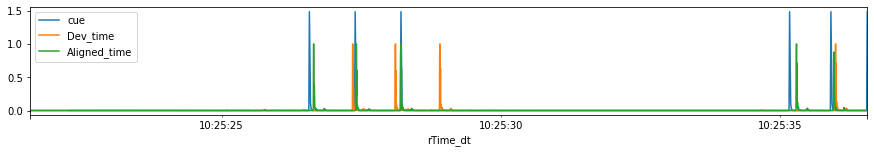

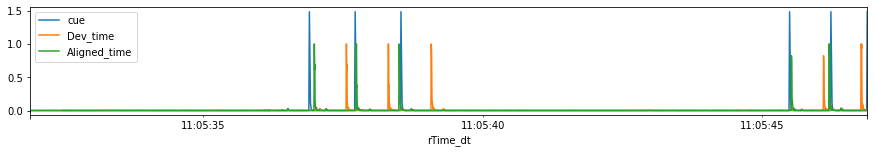

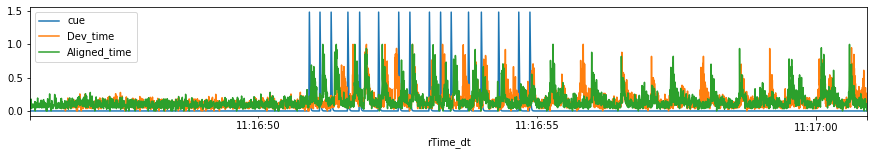

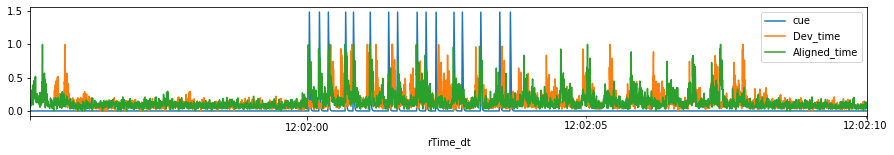

In [17]:
Results = {}
c_type = 'taps'
print(pid)
for c in refs:
    prelim_synch_time = synch_times[c]
    cue = CueT[c].copy()
    cue.loc[:,'dTime'] = pd.to_timedelta(cue['sTime'],unit='s')+prelim_synch_time
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]

    fig,ax = plt.subplots(1,1,figsize=(15,2))
    
    cue.plot.line(x='dTime',y=c_type,label='cue',ax=ax)
    
    X = ACC.loc[ACC['rTime_dt']<xrange[1],:].copy()
    X = X.loc[X['rTime_dt']>=xrange[0],:].copy()
    
    signal = X.loc[:,['dev_dTime','signal','rTime_dt']].copy()
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    
    signal.plot(x='dev_dTime',y='signal',label='Dev_time',ax=ax)
    signal.plot(x='rTime_dt',y='signal',label='Aligned_time',ax=ax)
    ax.set_xlim(xrange)
    plt.show()

# Shift and cut Equivitals
For each day, participant, and sensor, covert device time to recording time, and then save full concerts ON THE ORIGNAL SAMPLES just shifted. (Cut to pieces after concertwise)

file name output

20230215_C1/C1_FULL_BR601_EQACC.csv

Log the alignment parameters

PartID, Day, SENSOR_ID, starting ref Code,  starting ref in device time (UTC), starting shift in seconds, ending ref Code, ending ref in device time (UTC),  ending shift in seconds, scaling constant, Original recording file,  list of files output




### Prep EQ variables

In [21]:
Show_folder = {
    'RG':'../Data/Equivital/Aligned/20230215_RG/Full/',
    'RE':'../Data/Equivital/Aligned/20230215_RE/Full/',
    'RD':'../Data/Equivital/Aligned/20230215_RD/Full/',
    'C1':'../Data/Equivital/Aligned/20230216_C1/Full/',
    'C2':'../Data/Equivital/Aligned/20230216_C2/Full/',
    'C3':'../Data/Equivital/Aligned/20230217_C3/Full/',
    'C4':'../Data/Equivital/Aligned/20230217_C4/Full/',
    'C5':'../Data/Equivital/Aligned/20230218_C5/Full/'}

eq_sigs = {'DATA':'EQDATA','RR':'EQCIBI','RESPACC':'EQRESP','FASTACC':'EQBACC','ECG':'EQ2ECG'}

### Prep Shift variables

In [36]:
dev_scalings = pd.read_csv('Dev_scaling.csv')
dev_scalings#.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C']

,Dev_ID,PartID,Scaling_C
0,3420426,VN102,1.000129
1,5022006,VN107,1.000082
2,5022002,VN106,1.000074
3,5022009,VN108,1.000080
4,3420415,VN101,1.000130
...,...,...,...
63,14083,VN104,0.999998
64,17515,VN105,1.000003
65,17384,VN106,1.000012
66,14940,VN107,1.000002


In [22]:
cue_time_map = pd.DataFrame(index = cues_aligned.columns,columns = ['dt_UTC','cTime_s','rTime_s'])
cue_time_map['dt_UTC'] = pd.Series(synch_times)
rec_days = {'Re':['RE_Synch', 'RD_Synch', 'RD_Reic','RD_Reic2'], #, 'RD_Reic2'
            'D1':['C1_Synch', 'C1_Reic','C2_Synch', 'C2_Reic'],
           'D2':['C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic'],
            'D3':['C5_Synch', 'C5_Reic']}
sync_days = {'Re':'RE_Synch',
            'D1':'C1_Synch',
            'D2':'C3_Synch',
            'D3':'C5_Synch'}
shows_days = {'Re':['RG','RE','RD'],
            'D1':['C1','C2'],
            'D2':['C3','C4'],
            'D3':['C5']}
rec_con = {'RE':['RE_Synch'],
           'RD':['RD_Synch', 'RD_Reic','RD_Reic2'],#, 'RD_Reic2'
           'C1':['C1_Synch', 'C1_Reic'],
           'C2':['C2_Synch', 'C2_Reic'],
           'C3':['C3_Synch', 'C3_Reic'],
           'C4':[ 'C4_Synch', 'C4_Reic'],
           'C5':['C5_Synch', 'C5_Reic']}
sync_con = {'RG':'RE_Synch',
            'RE':'RE_Synch',
            'RD':'RD_Synch',
            'C1':'C1_Synch',
            'C2':'C2_Synch', 
            'C3':'C3_Synch',
            'C4':'C4_Synch',
            'C5':'C5_Synch'}

for s in rec_days.keys():
    cue_time_map.loc[rec_days[s],'rTime_s'] = (cue_time_map.loc[rec_days[s],'dt_UTC']-cue_time_map.loc[sync_days[s],'dt_UTC']).dt.total_seconds()
for s in rec_con.keys():
    cue_time_map.loc[rec_con[s],'cTime_s'] = (cue_time_map.loc[rec_con[s],'dt_UTC']-cue_time_map.loc[sync_con[s],'dt_UTC']).dt.total_seconds()

#cue_time_map.loc[[],'cTime_s'] = 
cue_time_map.to_csv('./Timing/cue_times_mapping.csv')
cue_time_map

,dt_UTC,cTime_s,rTime_s
RE_Synch,2023-02-15 10:25:26.573000+00:00,0.0,0.0
RD_Synch,2023-02-15 11:05:36.897000+00:00,0.0,2410.324
RD_Reic,2023-02-15 11:16:50.919000+00:00,674.022,3084.346
RD_Reic2,2023-02-15 12:02:00.040000+00:00,3383.143,5793.467
C1_Synch,2023-02-16 08:33:18.524000+00:00,0.0,0.0
C1_Reic,2023-02-16 08:45:22.446000+00:00,723.922,723.922
C2_Synch,2023-02-16 10:16:22.697000+00:00,0.0,6184.173
C2_Reic,2023-02-16 10:27:10.927000+00:00,648.23,6832.403
C3_Synch,2023-02-17 08:30:51.841000+00:00,0.0,0.0
C3_Reic,2023-02-17 08:40:31.007000+00:00,579.166,579.166


In [23]:
#Piece_timings, Piece_dt
Show_intervals = {
    'RG':[pd.to_datetime('2023-02-15 09:00:00.000+0000'),pd.to_datetime('2023-02-15 10:15:00.000+0000')],
    'RE':[pd.to_datetime('2023-02-15 10:13:00.000+0000'),pd.to_datetime('2023-02-15 10:28:00.000+0000')],
    'RD':[pd.to_datetime('2023-02-15 11:05:21.897+0000'),pd.to_datetime('2023-02-15 12:02:27.591+0000')],
    'C1':[pd.to_datetime('2023-02-16 08:33:03.524+0000'),pd.to_datetime('2023-02-16 09:36:09.960+0000')],
    'C2':[pd.to_datetime('2023-02-16 10:16:07.697+0000'),pd.to_datetime('2023-02-16 11:15:33.567+0000')],
    'C3':[pd.to_datetime('2023-02-17 08:30:36.841+0000'),pd.to_datetime('2023-02-17 09:30:11.399+0000')],
    'C4':[pd.to_datetime('2023-02-17 10:16:11.888+0000'),pd.to_datetime('2023-02-17 11:15:14.883+0000')],
    'C5':[pd.to_datetime('2023-02-18 15:10:14.583+0000'),pd.to_datetime('2023-02-18 16:10:47.401+0000')]}
Show_syncs = {
    'RG':pd.to_datetime('2023-02-15 09:00:00.000+0000'),
    'RE':pd.to_datetime('2023-02-15 10:13:00.000+0000'),
    'RD':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
    'C1':pd.to_datetime('2023-02-16 08:33:18.524+0000'),
    'C2':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
    'C3':pd.to_datetime('2023-02-17 08:30:51.841+0000'),
    'C4':pd.to_datetime('2023-02-17 10:16:26.888+0000'),
    'C5':pd.to_datetime('2023-02-18 15:10:29.583+0000')}

In [24]:
NODATE = pd.to_datetime('2023-02-15 25:25:26.573+0000', errors='coerce')

Align_Params = {'PartID':'','Day':'','DevID':'',
             'Cue0_code':'','Cue0_ddt':NODATE,'Cue0_rdt':NODATE,'Cue0_rst':np.nan,'Cue0_shift':np.nan,
             'Cue1_code':'','Cue1_ddt':NODATE,'Cue1_shift':np.nan,
            'Scaling_C':np.nan,'Source_filename':'','Output_files':[]}

### Test one one one
set PartID, Day, Concert, signal
Then output across all concerts on that day
Then output across signals

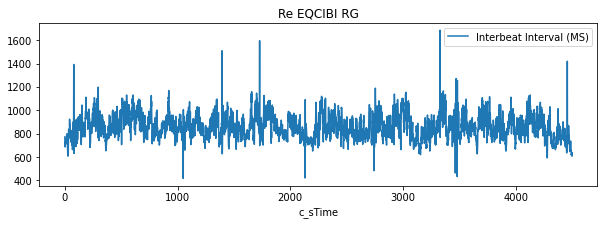

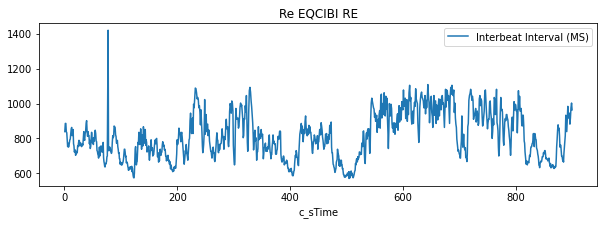

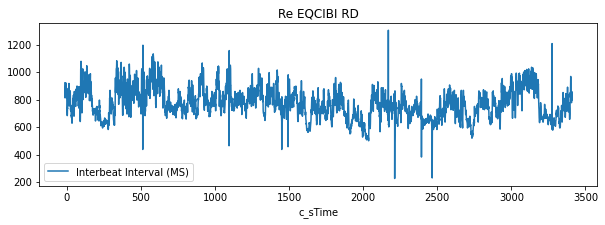

VN102 Re EQCIBI 0.719


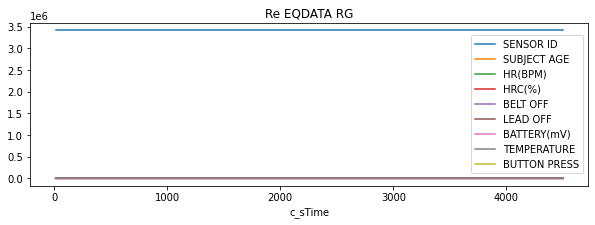

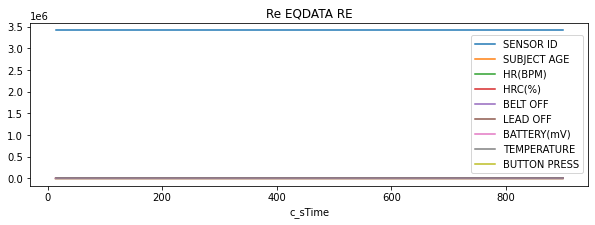

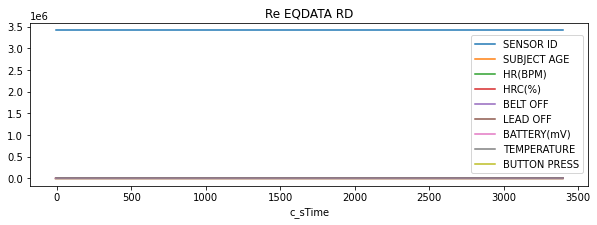

VN102 Re EQDATA 1.356


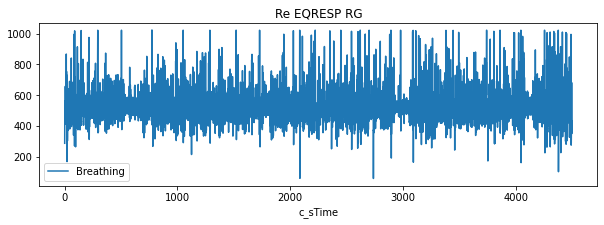

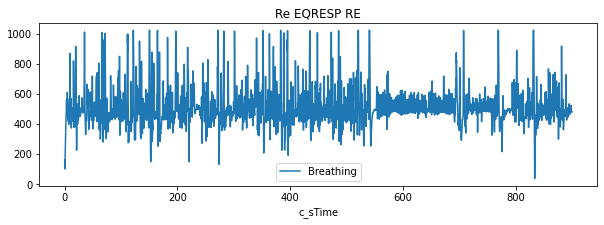

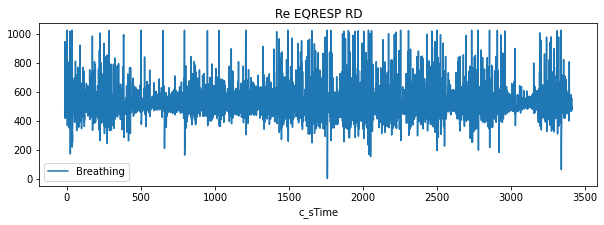

VN102 Re EQRESP 5.525


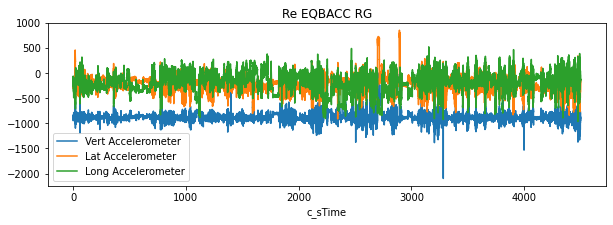

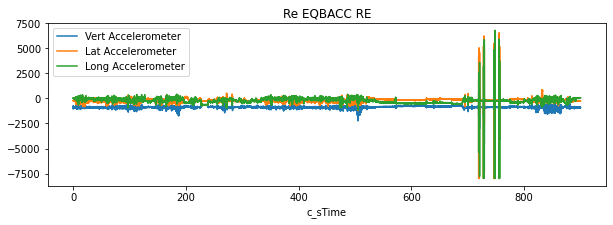

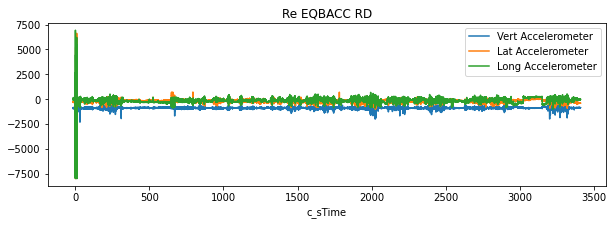

VN102 Re EQBACC 53.002


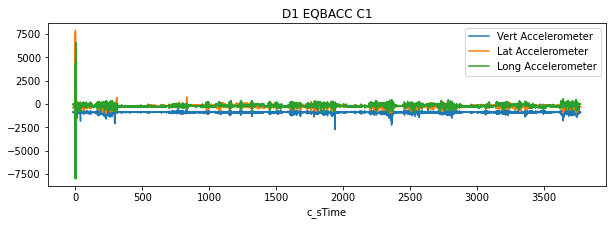

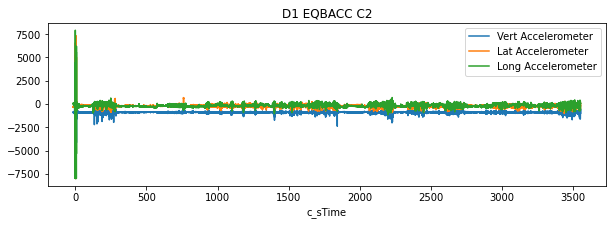

VN102 D1 EQBACC 32.64


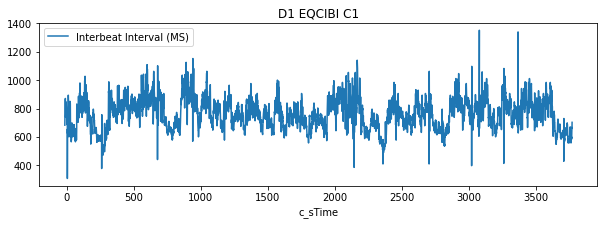

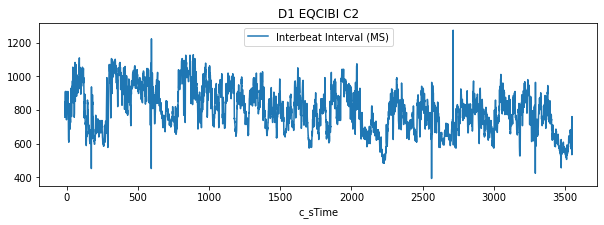

VN102 D1 EQCIBI 33.144


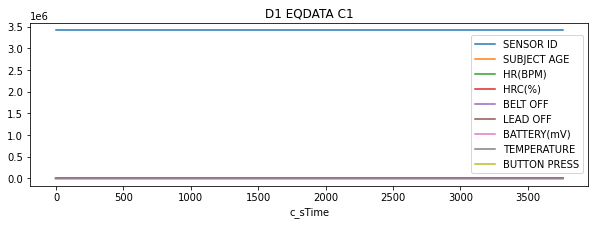

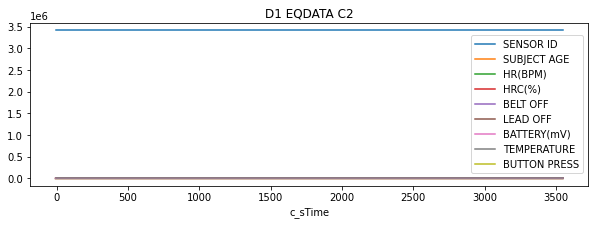

VN102 D1 EQDATA 33.563


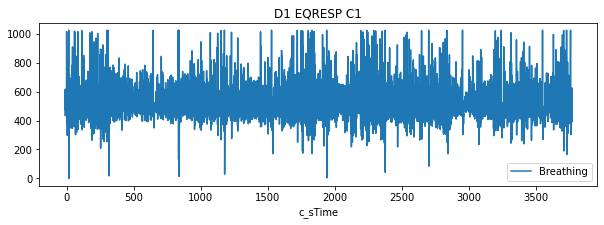

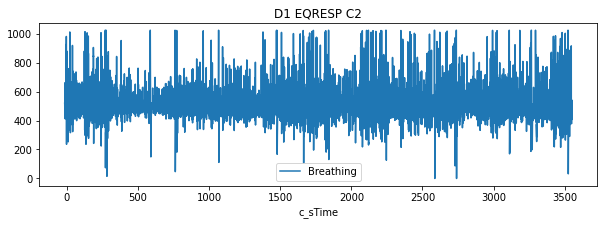

VN102 D1 EQRESP 36.842


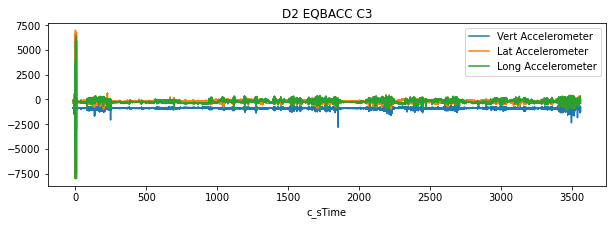

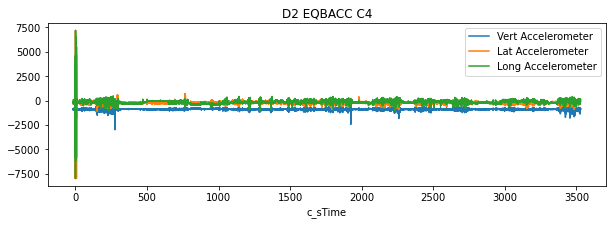

VN102 D2 EQBACC 30.063


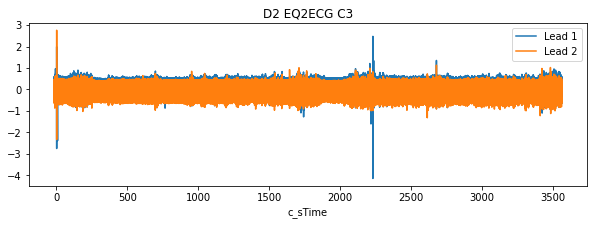

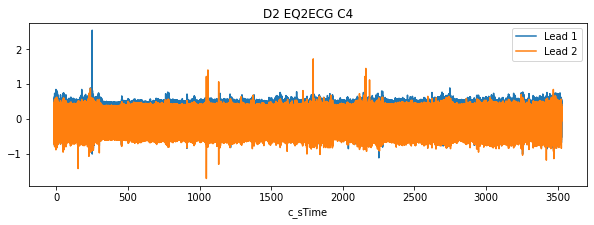

VN102 D2 EQ2ECG 62.085


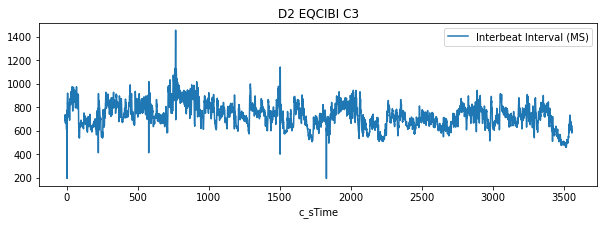

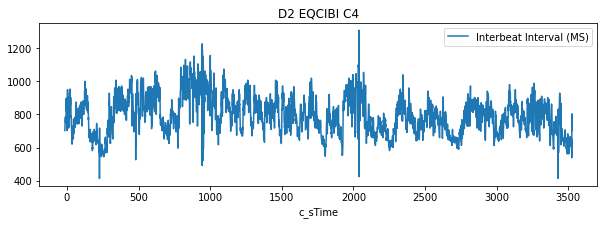

VN102 D2 EQCIBI 62.713


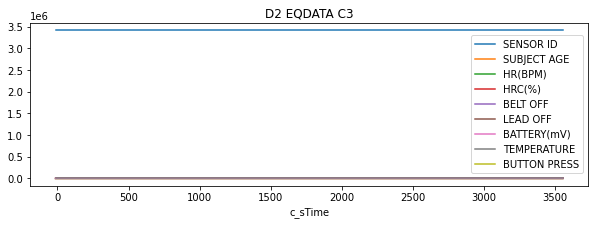

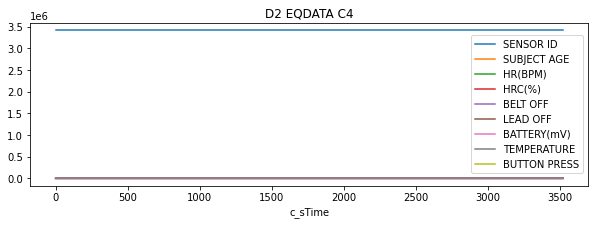

VN102 D2 EQDATA 63.117


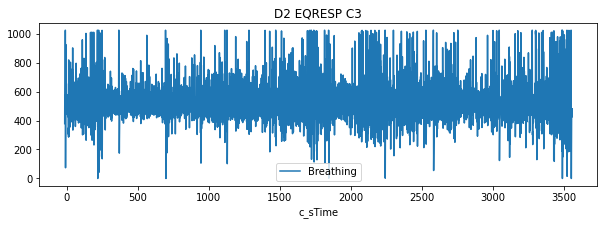

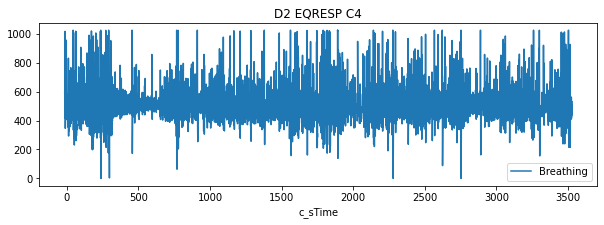

VN102 D2 EQRESP 66.288


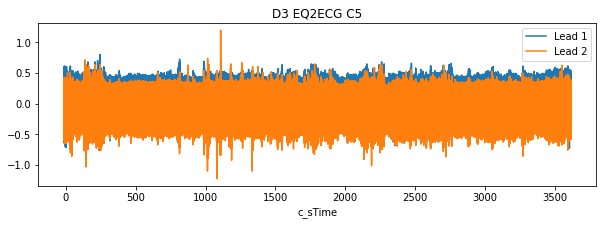

VN102 D3 EQ2ECG 15.162


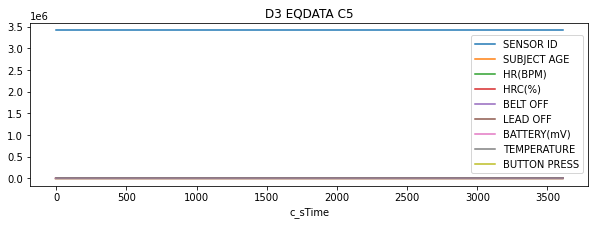

VN102 D3 EQDATA 15.378


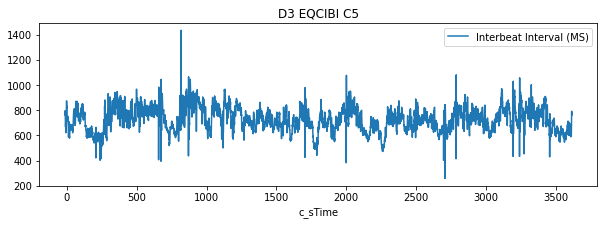

VN102 D3 EQCIBI 15.681


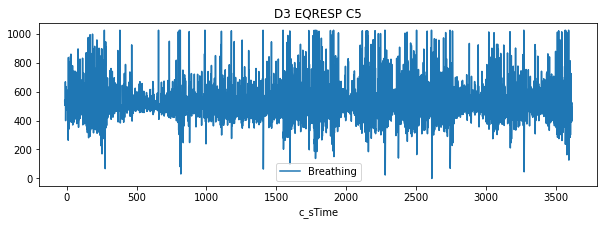

VN102 D3 EQRESP 17.385


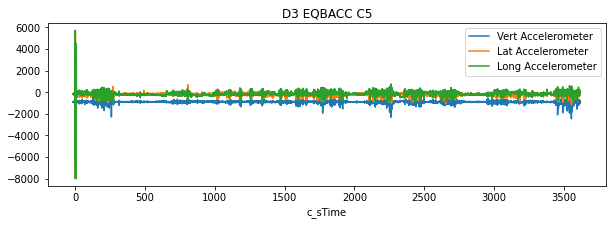

VN102 D3 EQBACC 32.176


,PartID,Day,DevID,Cue0_code,Cue0_ddt,Cue0_rdt,Cue0_rst,Cue0_shift,Cue1_code,Cue1_ddt,Cue1_shift,Scaling_C,Source_filename,Output_files
0,VN102,Re,3420426,RE_Synch,2023-02-15 10:25:26.493000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,0.08,RD_Reic2,2023-02-15 12:01:59.190000+00:00,0.85,1.000133,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN102...,"[RG_FULL_VN102_EQCIBI.csv, RE_FULL_VN102_EQCIB..."
1,VN102,D1,3420426,C1_Synch,2023-02-16 08:33:18.264000+00:00,2023-02-16 08:33:18.524000+00:00,0.0,0.26,C2_Reic,2023-02-16 10:27:09.787000+00:00,1.14,1.000129,../Data/Equivital/Lydo_C1_C2/FASTACC-VN102-342...,"[C1_FULL_VN102_EQBACC.csv, C2_FULL_VN102_EQBAC..."
2,VN102,D2,3420426,C3_Synch,2023-02-17 08:30:50.421000+00:00,2023-02-17 08:30:51.841000+00:00,0.0,1.42,C4_Reic,2023-02-17 10:27:18.499000+00:00,2.27,1.000122,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,"[C3_FULL_VN102_EQBACC.csv, C4_FULL_VN102_EQBAC..."
3,VN102,D3,3420426,C5_Synch,2023-02-18 15:10:32.123000+00:00,2023-02-18 15:10:29.583000+00:00,0.0,-2.54,,NaT,NaN,0.999871,../Data/Equivital/230218_Lydo_Concerts/FASTACC...,"[C5_FULL_VN102_EQ2ECG.csv, C5_FULL_VN102_EQDAT..."


In [35]:
ap = Align_Params.copy() # missing VN106 D2, minssing VN209 Re,  VN209 half of D1, single LS404 D3
CUTLOGS = pd.DataFrame(columns = ap.keys())
cut_ind = 0
pid = 'VN102'
for rec_day in rec_days.keys():
    tic = time.time()
    ap = Align_Params.copy() # missing VN106 D2, minssing VN209 Re,  VN209 half of D1, single LS404 D3
    ap['PartID'] = pid 
    ap['Day'] =  rec_day
    Concert = shows_days[ap['Day']][0] # should be the same for all shows
    ap['Source_filename'] = eq_files.loc[ap['PartID'],Concert]
    ap['DevID'] = ap['Source_filename'].split('-')[2] # equivital qiosk output filename convention

    # select cues
    refs = rec_days[ap['Day']]
    #sref = sync_days[ap['Day']]
    # for this recording interval and sensor, find the earliest and latest detected cues
    G = cues_aligned.loc[ap['PartID'],refs].copy()
    subrefs = list(G.loc[~pd.isnull(G)].index)

    if subrefs:
        # figure out realignment parameters for this device and recording interval
        if len(subrefs)==1:
            sref = subrefs[0]
            ap['Cue0_code'] = sref
            ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
            ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
            ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
            ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
            ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

        else:
            sref = subrefs[0]
            eref = subrefs[-1]
            if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
                # retain drift_C for stats
                ap['Cue0_code'] = sref
                ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                ap['Cue1_code'] = eref
                ap['Cue1_ddt'] = cues_aligned.loc[ap['PartID'],eref]
                ap['Cue1_shift'] = (cue_time_map.loc[eref,'dt_UTC']-cues_aligned.loc[ap['PartID'],eref]).total_seconds()
                ap['Scaling_C'] = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                                   /(ap['Cue1_ddt']-ap['Cue0_ddt']).total_seconds())
            else:
                sref = subrefs[0]
                ap['Cue0_code'] = sref
                ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

        # gather the signal files and cut them for these events
        rec_files = qex.matched_files(ap['Source_filename'],'/'.join(ap['Source_filename'].split('/')[:-1]),'/')
        outfiles = []
        for f in rec_files:
            if len(f.split('/'))>1:
                sig_file_type = f.split('/')[-1].split('-')[0]
                sig_type = eq_sigs[sig_file_type]

                V = pd.read_csv(f)
                dt_col = V.columns[0] # assume first column is time, specifically datetime
                sig_col = V.columns[1:]
                V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_convert('UTC') # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
                RecTimeSig = pd.DataFrame()
                RecTimeSig['rec_sTime'] = np.round((V[dt_col]-ap['Cue0_ddt']).dt.total_seconds()*ap['Scaling_C'],3)+ap['Cue0_rst']
                RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s') + ap['Cue0_rdt']
                RecTimeSig['dev_dTime'] = V[dt_col]
                RecTimeSig.loc[:,sig_col] = V[sig_col]

                new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']

                for ev in shows_days[ap['Day']]:
                    cuts = Show_intervals[ev]
                    subsig  = al.dt_cut(RecTimeSig,'rec_dTime',cuts[0],cuts[1])
                    subsig['c_sTime'] = (subsig['rec_dTime']-Show_syncs[ev]).dt.total_seconds()
                    seg_filename = ev + '_FULL_' + ap['PartID'] + '_' + sig_type + '.csv'
                    outfiles.append(seg_filename)
                    subsig[new_col_order].to_csv(Show_folder[ev] + seg_filename, index = False)

                    subsig.plot(x='c_sTime',y = sig_col,figsize=[10,3])
                    plt.title( ap['Day'] + ' ' + sig_type + ' ' + ev )
                    plt.show()

                print(' '.join([ap['PartID'],ap['Day'],sig_type,str(np.round(time.time() - tic,3))]))

        ap['Output_files'] = outfiles
        CUTLOGS.loc[cut_ind,:] = ap # it's growing slowly, chill pandas
        cut_ind += 1

    else:
        print('No signal for ' +ap['PartID'] + ' ' + ap['Day'])

CUTLOGS

In [37]:
#dict_keys(['Re', 'D1', 'D2', 'D3'])
shows_days['Re']

['RG', 'RE', 'RD']

# Produce Cut files for Equivital recordings
This will take a while

In [38]:
eq_files.index

Index(['VN102', 'VN107', 'VN106', 'VN108', 'VN101', 'VN105', 'VN103', 'VN104',
       'VN205', 'VN203', 'VN202', 'VN206', 'VN209', 'VN210', 'VN207', 'VN208',
       'VN201', 'VN204', 'VA305', 'VA307', 'VA308', 'VA301', 'VA306', 'VA302',
       'VA303', 'VA304', 'LS406', 'LS407', 'LS408', 'LS405', 'LS401', 'LS403',
       'LS402', 'LS410', 'LS404', 'WW505', 'WW502', 'WW503', 'WW506', 'WW501',
       'WW504', 'WW507', 'BR604', 'BR603', 'BR602', 'BR606', 'BR607', 'BR605',
       'BR601', 'PC704', 'PC705', 'PC703', 'PC701', 'PC702', 'PC707'],
      dtype='object')

VN102 Re EQBACC 37.136 37.138
VN102 D1 EQRESP 28.83 65.969
VN102 D2 EQRESP 54.874 120.844
VN102 D3 EQBACC 27.91 148.755
VN107 Re EQDATA 36.187 184.943
VN107 D1 EQBACC 29.485 214.429
VN107 D2 EQBACC 54.389 268.82
VN107 D3 EQCIBI 26.654 295.476
VN106 Re EQCIBI 34.657 330.134
VN106 D1 EQBACC 28.993 359.128
No signal for VN106 D2
VN106 D3 EQ2ECG 26.941 386.073
VN108 Re EQBACC 35.305 421.379
VN108 D1 EQDATA 28.911 450.291
VN108 D2 EQDATA 54.099 504.392
VN108 D3 EQBACC 28.319 532.712
VN101 Re EQBACC 40.239 572.952
VN101 D1 EQRESP 33.06 606.013
VN101 D2 EQRESP 58.419 664.434
VN101 D3 EQBACC 27.609 692.044
VN105 Re EQBACC 35.286 727.331
VN105 D1 EQRESP 29.608 756.94
VN105 D2 EQRESP 56.008 812.95
VN105 D3 EQBACC 27.0 839.951
VN103 Re EQBACC 34.724 874.676
VN103 D1 EQDATA 28.483 903.161
VN103 D2 EQDATA 54.136 957.299
VN103 D3 EQBACC 28.427 985.726
VN104 Re EQRESP 42.867 1028.595
VN104 D1 EQBACC 30.579 1059.175
VN104 D2 EQBACC 57.438 1116.614
VN104 D3 EQRESP 27.687 1144.302
VN205 Re EQBACC 36.648

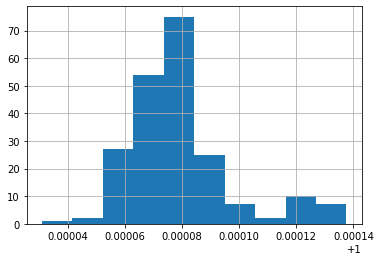

,PartID,Day,DevID,Cue0_code,Cue0_ddt,Cue0_rdt,Cue0_rst,Cue0_shift,Cue1_code,Cue1_ddt,Cue1_shift,Scaling_C,Source_filename,Output_files
0,VN102,Re,3420426,RE_Synch,2023-02-15 10:25:26.493000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,0.08,RD_Reic2,2023-02-15 12:01:59.190000+00:00,0.85,1.000133,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN102...,"[RG_FULL_VN102_EQCIBI.csv, RE_FULL_VN102_EQCIB..."
1,VN102,D1,3420426,C1_Synch,2023-02-16 08:33:18.264000+00:00,2023-02-16 08:33:18.524000+00:00,0.0,0.26,C2_Reic,2023-02-16 10:27:09.787000+00:00,1.14,1.000129,../Data/Equivital/Lydo_C1_C2/FASTACC-VN102-342...,"[C1_FULL_VN102_EQBACC.csv, C2_FULL_VN102_EQBAC..."
2,VN102,D2,3420426,C3_Synch,2023-02-17 08:30:50.421000+00:00,2023-02-17 08:30:51.841000+00:00,0.0,1.42,C4_Reic,2023-02-17 10:27:18.499000+00:00,2.27,1.000122,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,"[C3_FULL_VN102_EQBACC.csv, C4_FULL_VN102_EQBAC..."
3,VN102,D3,3420426,C5_Synch,2023-02-18 15:10:32.123000+00:00,2023-02-18 15:10:29.583000+00:00,0.0,-2.54,,NaT,NaN,1.000129,../Data/Equivital/230218_Lydo_Concerts/FASTACC...,"[C5_FULL_VN102_EQ2ECG.csv, C5_FULL_VN102_EQDAT..."
4,VN107,Re,5022006,RD_Reic,2023-02-15 11:16:53.069000+00:00,2023-02-15 11:16:50.919000+00:00,3084.346,-2.15,,NaT,NaN,1.000082,../Data/Equivital/Lydo_Rehearsal/FASTACC-VN107...,"[RG_FULL_VN107_EQBACC.csv, RE_FULL_VN107_EQBAC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,PC702,D3,5022240,C5_Synch,2023-02-18 15:10:32.703000+00:00,2023-02-18 15:10:29.583000+00:00,0.0,-3.12,,NaT,NaN,1.00007,../Data/Equivital/230218_Lydo_Concerts/FASTACC...,"[C5_FULL_PC702_EQ2ECG.csv, C5_FULL_PC702_EQRES..."
206,PC707,Re,5022256,RE_Synch,2023-02-15 10:25:27.853000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,-1.28,RD_Reic2,2023-02-15 12:02:00.870000+00:00,-0.83,1.000078,../Data/Equivital/Lydo_Rehearsal/FASTACC-PC707...,"[RG_FULL_PC707_EQBACC.csv, RE_FULL_PC707_EQBAC..."
207,PC707,D1,5022256,C1_Synch,2023-02-16 08:33:19.484000+00:00,2023-02-16 08:33:18.524000+00:00,0.0,-0.96,C2_Reic,2023-02-16 10:27:11.187000+00:00,-0.26,1.000102,../Data/Equivital/Lydo_C1_C2/FASTACC-PC707-502...,"[C1_FULL_PC707_EQCIBI.csv, C2_FULL_PC707_EQCIB..."
208,PC707,D2,5022256,C3_Synch,2023-02-17 08:30:52.561000+00:00,2023-02-17 08:30:51.841000+00:00,0.0,-0.72,C4_Reic,2023-02-17 10:27:20.899000+00:00,-0.13,1.000084,../Data/Equivital/230217_Lydo_Concerts/CSV/FAS...,"[C3_FULL_PC707_EQBACC.csv, C4_FULL_PC707_EQBAC..."


In [40]:
CUTLOGS = pd.DataFrame(columns = ap.keys())
cut_ind = 0
toc = time.time()

for pid in eq_files.index:
    for rec_day in rec_days.keys():
        tic = time.time()
        ap = Align_Params.copy() # missing VN106 D2, minssing VN209 Re,  VN209 half of D1, single LS404 D3
        ap['PartID'] = pid 
        ap['Day'] =  rec_day
        Concert = shows_days[ap['Day']][0] # should be the same for all shows
        ap['Source_filename'] = eq_files.loc[ap['PartID'],Concert]
        ap['DevID'] = ap['Source_filename'].split('-')[2] # equivital qiosk output filename convention

        # select cues
        refs = rec_days[ap['Day']]
        #sref = sync_days[ap['Day']]
        # for this recording interval and sensor, find the earliest and latest detected cues
        G = cues_aligned.loc[ap['PartID'],refs].copy()
        subrefs = list(G.loc[~pd.isnull(G)].index)

        if subrefs:
            # figure out realignment parameters for this device and recording interval
            if len(subrefs)==1:
                sref = subrefs[0]
                ap['Cue0_code'] = sref
                ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

            else:
                sref = subrefs[0]
                eref = subrefs[-1]
                if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
                    # retain drift_C for stats
                    ap['Cue0_code'] = sref
                    ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                    ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                    ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                    ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                    ap['Cue1_code'] = eref
                    ap['Cue1_ddt'] = cues_aligned.loc[ap['PartID'],eref]
                    ap['Cue1_shift'] = (cue_time_map.loc[eref,'dt_UTC']-cues_aligned.loc[ap['PartID'],eref]).total_seconds()
                    ap['Scaling_C'] = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                                       /(ap['Cue1_ddt']-ap['Cue0_ddt']).total_seconds())
                else:
                    sref = subrefs[0]
                    ap['Cue0_code'] = sref
                    ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                    ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                    ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                    ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                    ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

            # gather the signal files and cut them for these events
            rec_files = qex.matched_files(ap['Source_filename'],'/'.join(ap['Source_filename'].split('/')[:-1]),'/')
            outfiles = []
            for f in rec_files:
                if len(f.split('/'))>1:
                    sig_file_type = f.split('/')[-1].split('-')[0]
                    sig_type = eq_sigs[sig_file_type]

                    V = pd.read_csv(f)
                    dt_col = V.columns[0] # assume first column is time, specifically datetime
                    sig_col = V.columns[1:]
                    V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_convert('UTC') # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
                    RecTimeSig = pd.DataFrame()
                    RecTimeSig['rec_sTime'] = np.round((V[dt_col]-ap['Cue0_ddt']).dt.total_seconds()*ap['Scaling_C'],3)+ap['Cue0_rst']
                    RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s') + ap['Cue0_rdt']
                    RecTimeSig['dev_dTime'] = V[dt_col]
                    RecTimeSig.loc[:,sig_col] = V[sig_col]

                    new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']

                    for ev in shows_days[ap['Day']]:
                        cuts = Show_intervals[ev]
                        subsig  = al.dt_cut(RecTimeSig,'rec_dTime',cuts[0],cuts[1])
                        subsig['c_sTime'] = (subsig['rec_dTime']-Show_syncs[ev]).dt.total_seconds()
                        seg_filename = ev + '_FULL_' + ap['PartID'] + '_' + sig_type + '.csv'
                        outfiles.append(seg_filename)
                        subsig[new_col_order].to_csv(Show_folder[ev] + seg_filename, index = False)

            print(' '.join([ap['PartID'],ap['Day'],sig_type,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))
            ap['Output_files'] = outfiles
            CUTLOGS.loc[cut_ind,:] = ap # it's growing slowly, chill pandas
            cut_ind += 1

        else:
            print('No signal for ' +ap['PartID'] + ' ' + ap['Day'])

CUTLOGS.to_csv('./out_data/EQIVITALS_CUTLOGS.csv')
CUTLOGS['Scaling_C'].hist()
plt.show()
CUTLOGS

In [ ]:
CUTLOGS.to_csv('./out_data/EQIVITALS_CUTLOGS.csv')

In [41]:
ap

{'PartID': 'PC707',
 'Day': 'D3',
 'DevID': '5022256',
 'Cue0_code': 'C5_Synch',
 'Cue0_ddt': Timestamp('2023-02-18 15:10:32.913000+0000', tz='UTC'),
 'Cue0_rdt': Timestamp('2023-02-18 15:10:29.583000+0000', tz='UTC'),
 'Cue0_rst': 0.0,
 'Cue0_shift': -3.33,
 'Cue1_code': '',
 'Cue1_ddt': NaT,
 'Cue1_shift': nan,
 'Scaling_C': 1.0000776797306137,
 'Source_filename': '../Data/Equivital/230218_Lydo_Concerts/FASTACC-PC707-5022256-23021800-cut.csv',
 'Output_files': ['C5_FULL_PC707_EQBACC.csv',
  'C5_FULL_PC707_EQDATA.csv',
  'C5_FULL_PC707_EQCIBI.csv',
  'C5_FULL_PC707_EQRESP.csv',
  'C5_FULL_PC707_EQ2ECG.csv']}

# show alignment results

In [51]:
player_order = ['VN102', 'VN107', 'VN106', 'VN108', 'VN101', 'VN105', 'VN103', 'VN104',
       'VN205', 'VN203', 'VN202', 'VN206', 'VN209', 'VN210', 'VN207', 'VN208',
       'VN201', 'VN204', 'VA305', 'VA307', 'VA308', 'VA301', 'VA306', 'VA302',
       'VA303', 'VA304', 'LS406', 'LS407', 'LS408', 'LS405', 'LS401', 'LS403',
       'LS402', 'LS410', 'LS404', 'WW505', 'WW502', 'WW503', 'WW506', 'WW501',
       'WW504', 'WW507', 'BR604', 'BR603', 'BR602', 'BR606', 'BR607', 'BR605',
       'BR601', 'PC704', 'PC705', 'PC703', 'PC701', 'PC702', 'PC707']

In [60]:
ev = 'C2'
datafile_type = 'EQDATA'
sigName = 'HR(BPM)'
files = os.listdir(data_loc)
files.sort()
sig_files = {}
for f in files: 
    if f.endswith(datafile_type+'.csv'): 
        partID = f.split('_')[2]
        sig_files[partID] = data_loc+f
sig_files

sf = 0.1 # hz 
s_time = Piece_timings.loc[3,ev]
s_dtime = Piece_dt.loc[3,ev]
e_time =  Piece_timings.loc[33,ev]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
time_dt = s_dtime + pd.to_timedelta(time_s,unit='s')

In [68]:
df_sig = pd.DataFrame(index = time_s,columns = player_order,dtype='float') # Piece_timings.loc[2,ev]
# ACC
for partID in sig_files.keys(): #['c_sTime']
    V = pd.read_csv(sig_files[partID])
    sig_t = V['c_sTime']
    if sigName == 'QoM':
        sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
    else:
        if sigName in V.columns:
            sig_v = V[sigName].values
            
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
    df_sig.loc[:,partID] = new_sig

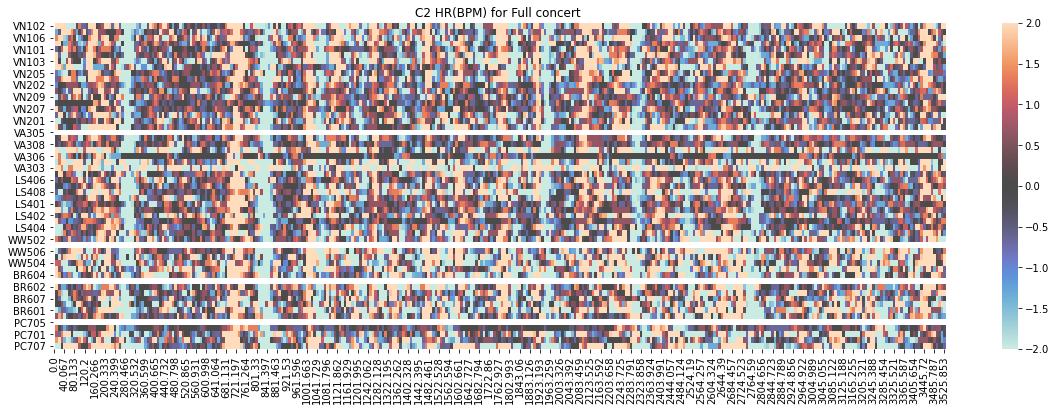

In [73]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=df_sig.diff().transpose(), ax=ax1,vmin=-2, vmax=2, cbar=True,cmap='icefire',alpha=0.8)
plt.title(ev + ' ' + sigName + ' for Full concert ')
plt.show()

In [777]:
# t1 = Piece_timings.loc[2,ev]
# t2 = Piece_timings.loc[33,ev]
t1 = 216.17
t2 = 246.17
interval_name = 'Full'
sub_sig = df_sig.loc[t1:t2,:].copy()
sub_sig.fillna(sub_sig.mean().mean(),inplace = True)

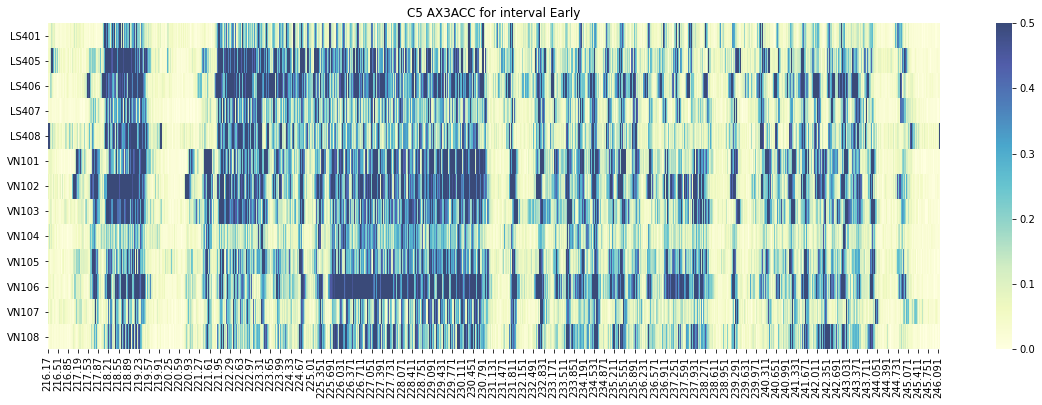

In [693]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title(ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

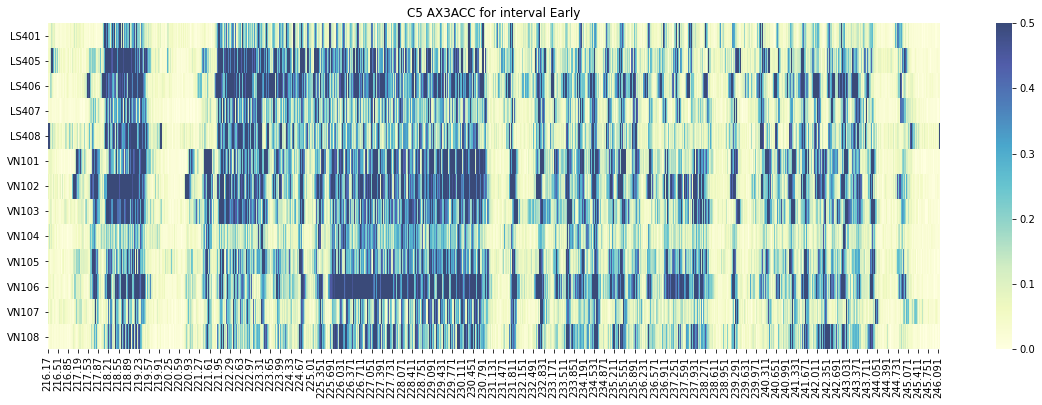

In [693]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title(ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

Or on equivital recordings

In [805]:
ev = 'C5'
data_loc = '../Data/Equivital/Aligned/20230218_C5/Full/'
files = os.listdir(data_loc)
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
files.sort()
files[:5]

# signal File type and column name (multi sample)
sf = 25 # hz 
s_time = Piece_timings.loc[3,ev]
s_dtime = Piece_dt.loc[3,ev]
e_time =  Piece_timings.loc[33,ev]
sigFile = 'EQRESP'
sigName = 'Breathing'
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
time_dt = s_dtime + pd.to_timedelta(time_s,unit='s')

In [809]:
df_sig = pd.DataFrame(index = time_s,columns = player_order) # Piece_timings.loc[2,ev]

# equivitals
for f in files: #['c_sTime']
    if sigFile in f:
        PartName = f.split('_')[2]
        V = pd.read_csv(data_loc+f,skipinitialspace=True)
        sig_t = V['c_sTime']
        if sigName=='ACC': 
            df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
            sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        else:
            sig_v = (V[sigName]-V[sigName].mean())/V[sigName].diff().abs().std()
        f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
         #   if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
        df_sig.loc[:,PartName] = new_sig

In [810]:
t1 = Piece_timings.loc[31,ev]
t2 = Piece_timings.loc[32,ev]
interval_name = 'diff_Stra'
sub_sig = df_sig.loc[t1:t2,:].copy().diff()
sub_sig.fillna(sub_sig.mean().mean(),inplace = True)

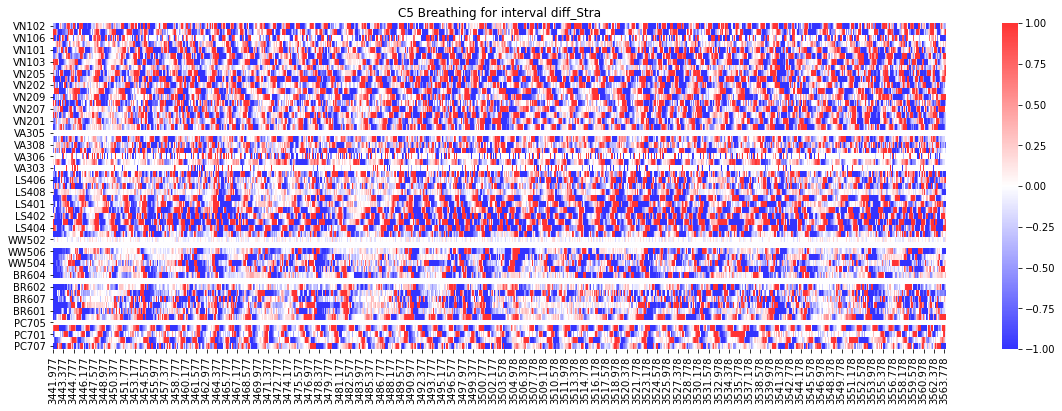

In [811]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6]) #vmin=0, vmax=0.5, ,vmin=-5, vmax=5 cmap="bwr"
#chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=40, vmax=160,cbar=True,cmap="YlGnBu",alpha=0.8)
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=-1, vmax=1,cbar=True,cmap="bwr",alpha=0.8)

plt.title(ev + ' ' + sigName + ' for interval ' + interval_name)
plt.savefig('./plots/'+ev+'_'+ interval_name + '_set_'+sigName+'.png',dpi = 300)
plt.show()